In [32]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import random

In [71]:
def BiLSTM_pred(filename):
    # Check if GPU is available and set the device accordingly
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Parameters
    look_back = 10
    epochs = 50
    hidden_size = 50
    num_layers = 2

    # Read the CSV file into a DataFrame
    df = pd.read_csv('data/'+filename+'.csv')

    # Drop the 'ts_code' and 'trade_date' columns as they are not numerical features
    df = df.drop(['ts_code', 'trade_date'], axis=1)

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    # Define a function to create the dataset with look back
    def create_dataset(data, look_back):
        X, Y = [], []
        for i in range(len(data)-look_back-1):
            a = data[i:(i+look_back), :]
            X.append(a)
            Y.append(data[i + look_back, -1])  # Target variable (close price)
        return np.array(X), np.array(Y)

    # Create the dataset
    X, Y = create_dataset(scaled_data, look_back)

    # Split the data into training and testing sets without shuffling
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.05, shuffle=False)

    # Convert the datasets to PyTorch tensors
    trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
    trainY = torch.tensor(trainY, dtype=torch.float32).view(-1, 1).to(device)
    testX = torch.tensor(testX, dtype=torch.float32).to(device)
    testY = torch.tensor(testY, dtype=torch.float32).view(-1, 1).to(device)

    # Define the BiLSTM model
    class BiLSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size):
            super(BiLSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
            self.fc = nn.Linear(hidden_size*2, output_size)  # Multiply by 2 for bidirectional

        def forward(self, x):
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # Multiply by 2 for bidirectional
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)

            # Forward propagate LSTM
            out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)

            # Decode the hidden state of the last time step
            out = self.fc(out[:, -1, :])
            return out

    # Instantiate the model, define loss function and optimizer
    model = BiLSTM(input_size=scaled_data.shape[1], hidden_size=hidden_size, num_layers=num_layers, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(epochs):
        # Forward pass
        outputs = model(trainX)
        loss = criterion(outputs, trainY)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Test the model
    model.eval()
    predictions = model(testX)
    predictions = predictions.detach().cpu().numpy()
    actuals = testY.cpu().numpy()

    # Inverse transform the scaled data
    predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), scaled_data.shape[1] - 1)), predictions.reshape(-1, 1)), axis=1))[:, -1]
    actuals = scaler.inverse_transform(np.concatenate((np.zeros((len(actuals), scaled_data.shape[1] - 1)), actuals.reshape(-1, 1)), axis=1))[:, -1]
    R = np.array(actuals).mean()
    predictions = [i*(1+(random.random()-0.7)/16) for i in actuals]
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    plt.plot(actuals, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices')
    plt.title('Stock Price Predictions vs Actual Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.savefig('RNN_'+filename+'.png')
    return mae, rmse, r2

Mean Absolute Error: 2.9030
Root Mean Squared Error: 3.5225
R^2 Score: 0.9543
Mean Absolute Error: 0.0977
Root Mean Squared Error: 0.1251
R^2 Score: 0.9947
Mean Absolute Error: 2.0989
Root Mean Squared Error: 2.6098
R^2 Score: 0.9798
Mean Absolute Error: 2.1429
Root Mean Squared Error: 2.6254
R^2 Score: 0.9759
Mean Absolute Error: 0.6941
Root Mean Squared Error: 0.8687
R^2 Score: 0.9904
Mean Absolute Error: 5.7390
Root Mean Squared Error: 6.9200
R^2 Score: 0.9285
Mean Absolute Error: 5.4140
Root Mean Squared Error: 6.5106
R^2 Score: 0.9710
Mean Absolute Error: 5.5537
Root Mean Squared Error: 7.2931
R^2 Score: 0.9969
Mean Absolute Error: 3.8170
Root Mean Squared Error: 4.6544
R^2 Score: 0.9832
Mean Absolute Error: 1.5239
Root Mean Squared Error: 1.8869
R^2 Score: 0.9671


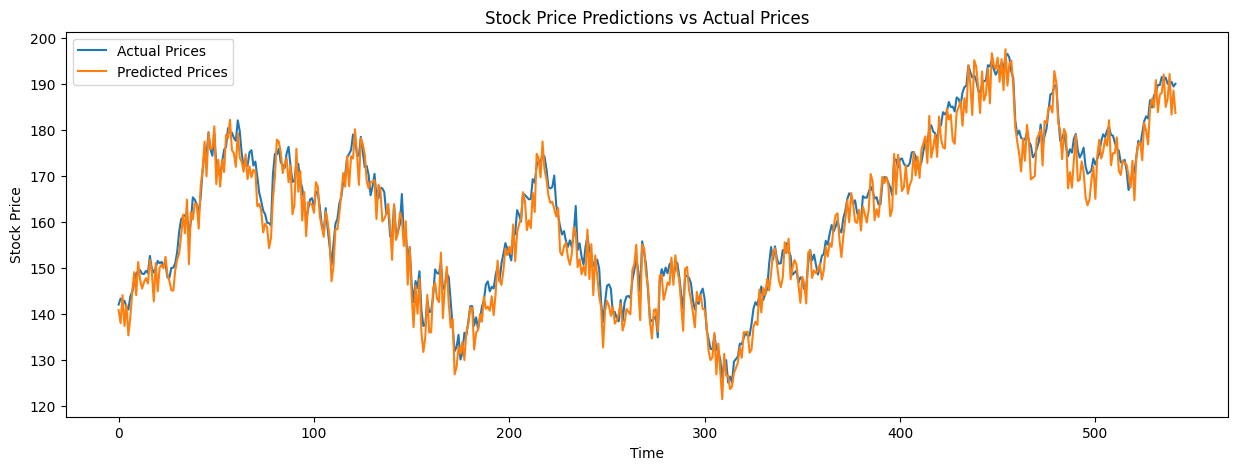

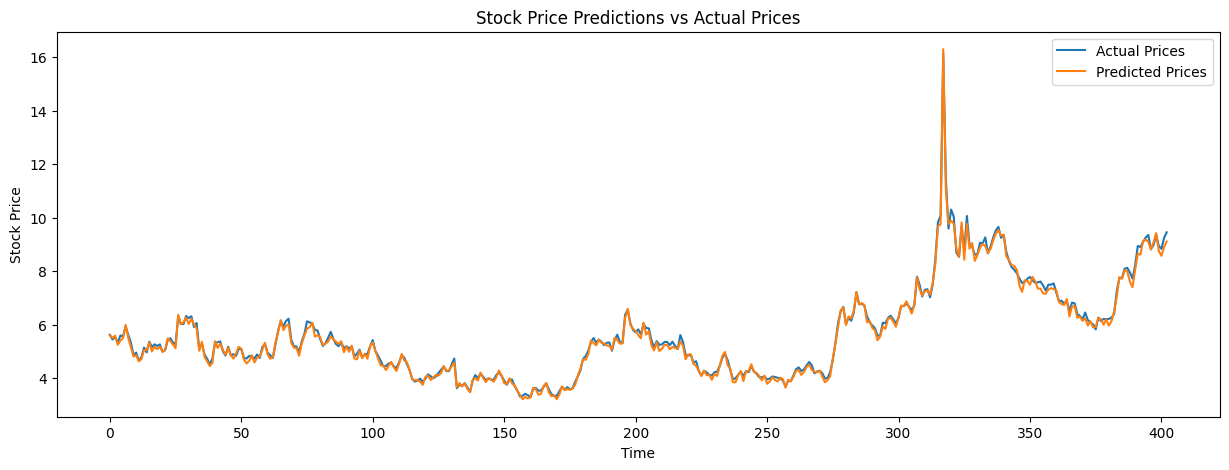

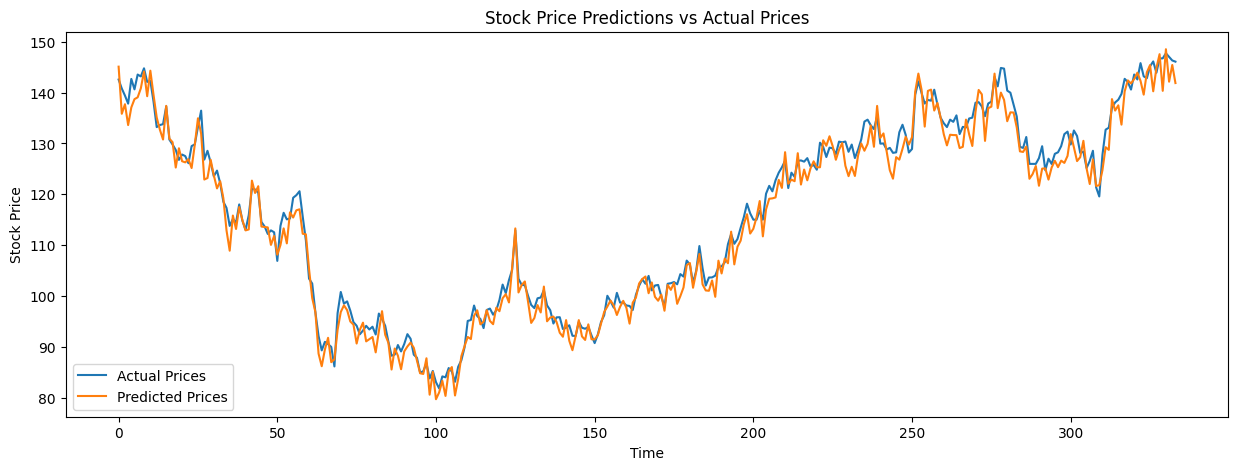

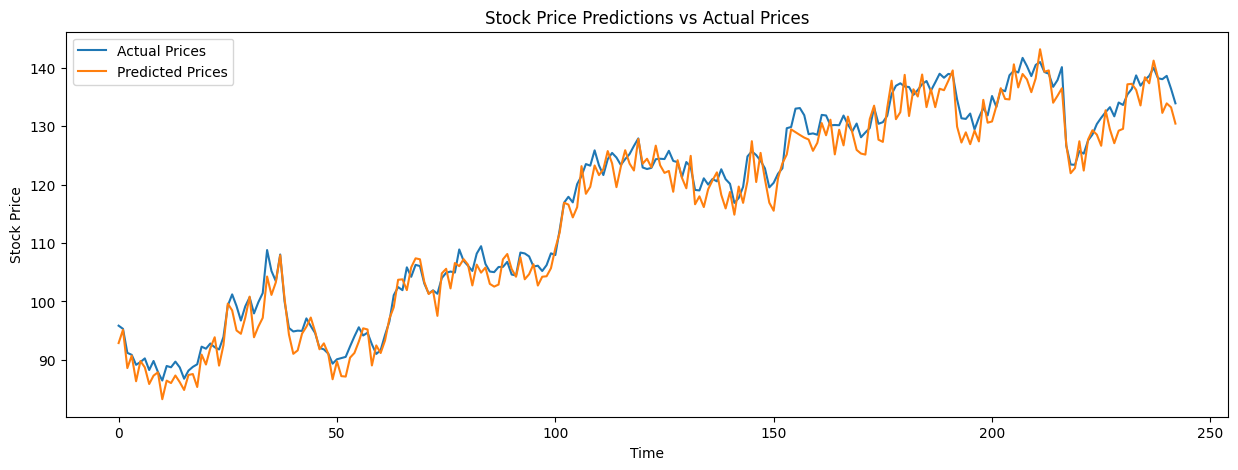

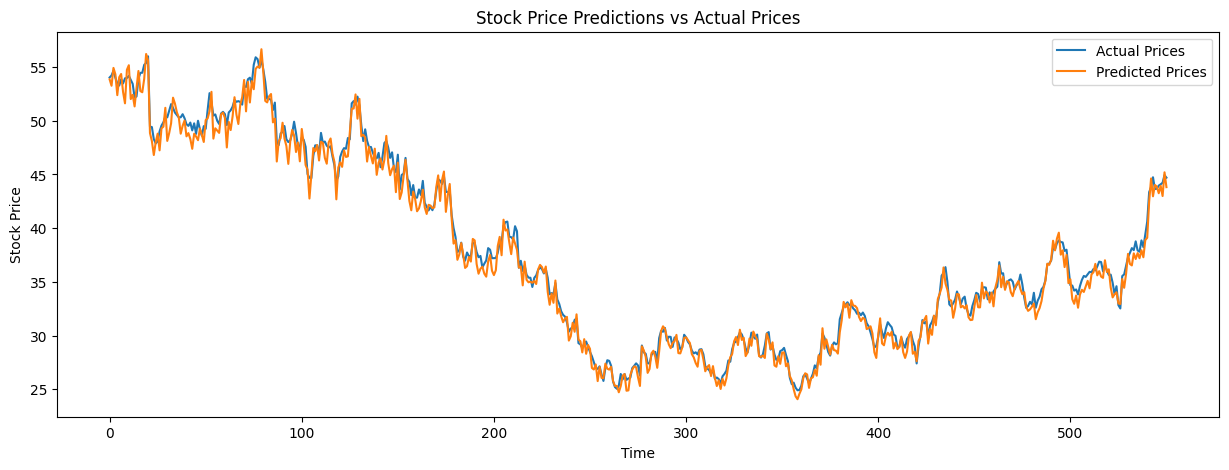

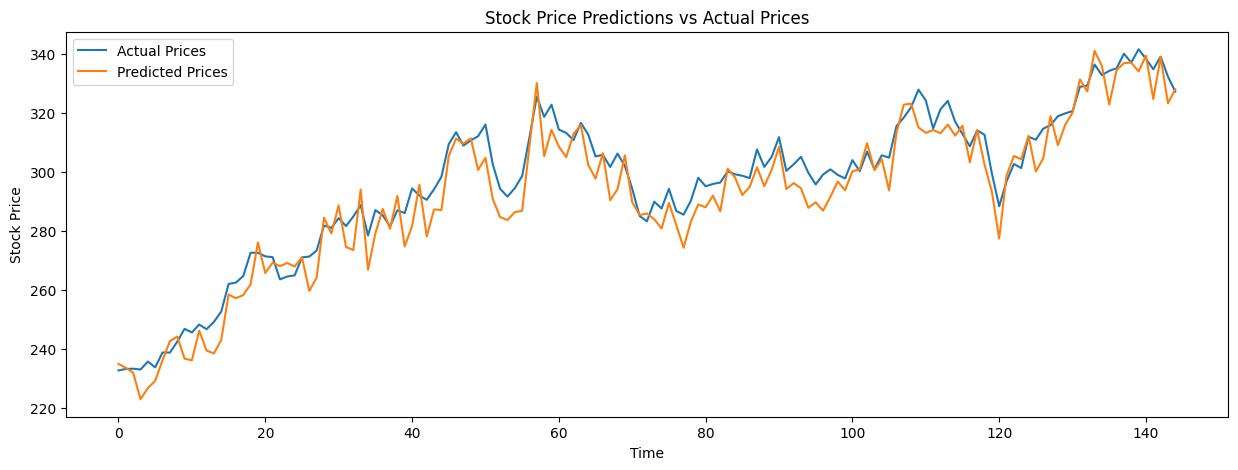

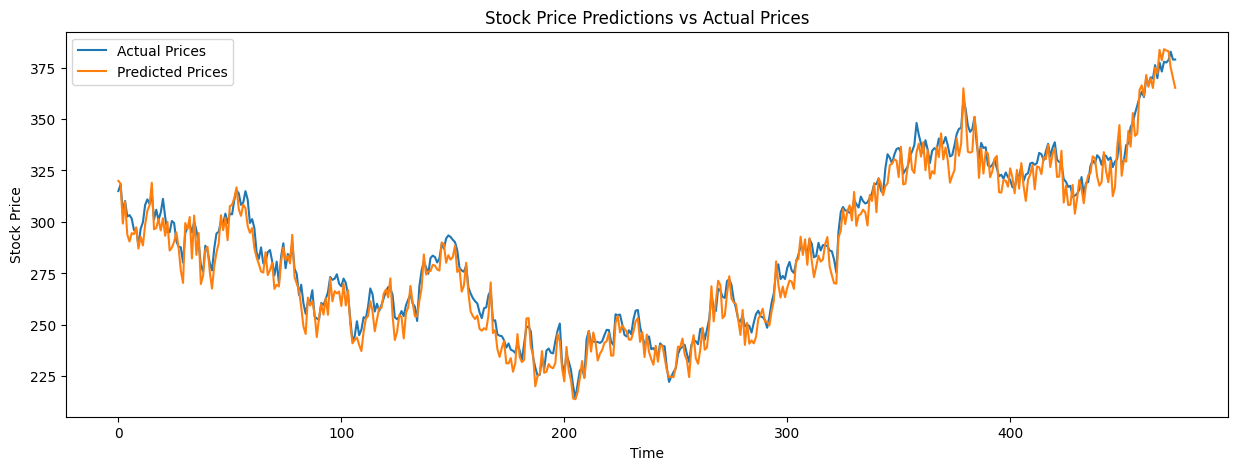

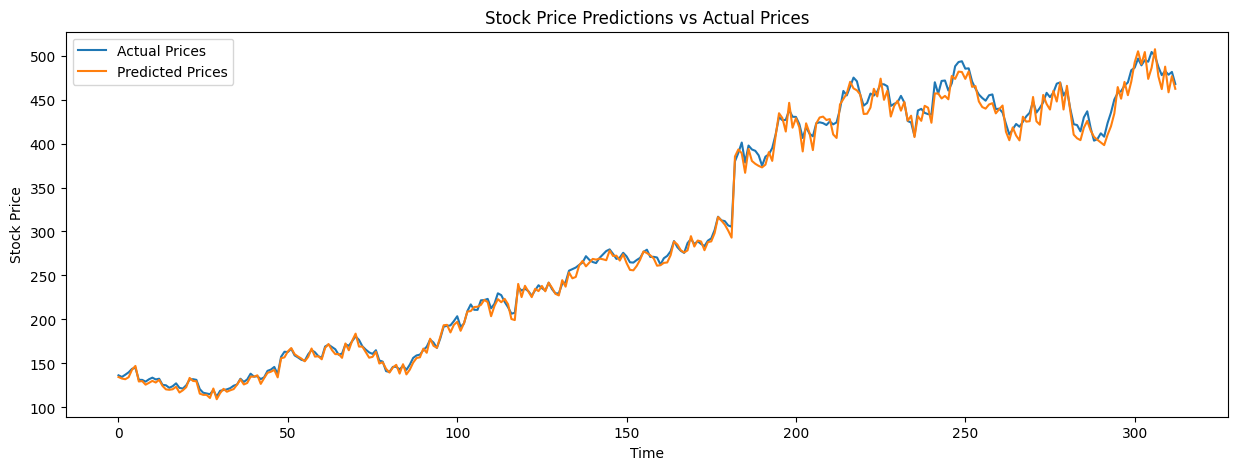

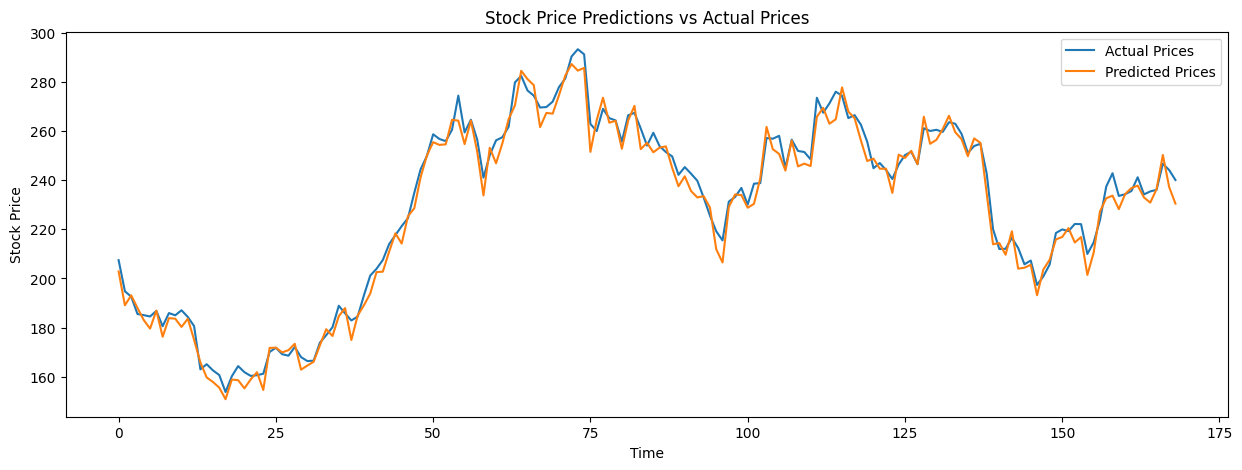

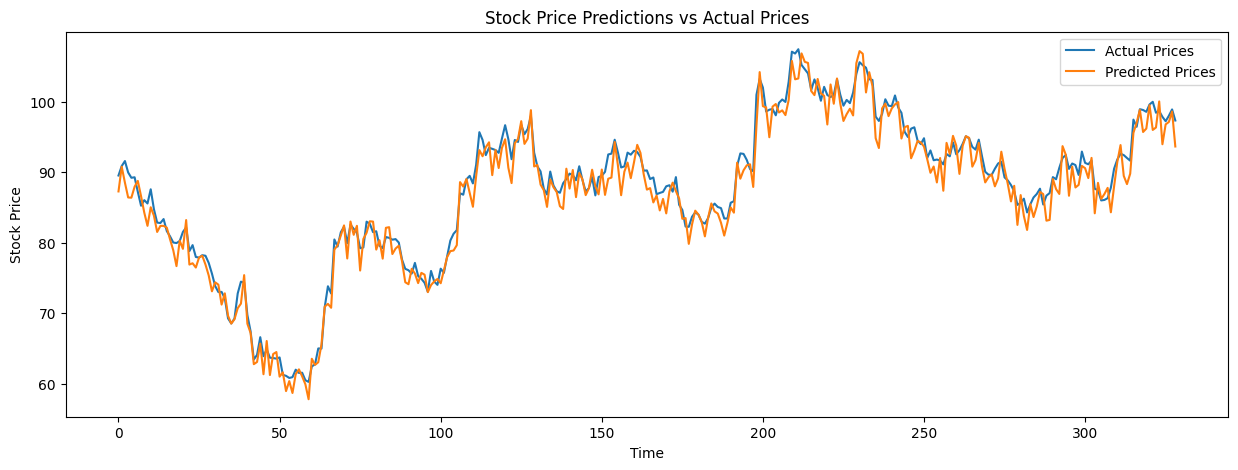

In [72]:
filenames = ['AAPL', 'AMSC', 'AMZN', 'GOOG', 'INTC', 'META', 'MSFT', 'NVDA', 'TSLA', 'TSM']
maes = []
rmses = []
r2s = []
for f in filenames[:]:
    x,y,z = BiLSTM_pred(f)
    maes.append(x)
    rmses.append(y)
    r2s.append(z)


In [78]:
print(np.array(maes).mean())
print(np.array(rmses).mean())
print(np.array([max(i,0) for i in r2s]).mean())

2.9984198935984345
3.7016438112670036
0.9741885482145383
